# Curiosities of European Soccer

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This data set from Kaggle brings data of soccer from european leagues, teams and players from 2008 to 2016.
* +25,000 matches
* +10,000 players
* 11 European Countries with their lead championship

Some question we will try to answer here in this work:

<ul>
<li><a href="#question1">1. Who are the best players on Europe (better rating)?</a></li>
<li><a href="#question2">2. Who are the players with higher aggression rating?</a></li>
<li><a href="#question3">3. Is the player rating related to agressiveness?</a></li>
<li><a href="#question4">4. How the players are distributed by their physical form (measured by the Body Mass Index).</a></li>
<li><a href="#question5">5. Teams playing at home won more matchs?</a></li>
<li><a href="#question6">6. What teams attributes have correlation with victory when playing at home?</a></li>
</ul>

Import libs used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Load data for Players from database.sqlite witch is in the same folder of the notebook.
The columns 'overall_rating' and 'penalties' will be used to answer some questions.

In [2]:
# A function to load data from DB.
def load_data(query):
    with sqlite3.connect('database.sqlite') as con:
        df = pd.read_sql_query(query, con)
    
    return df

In [3]:
players_query = '''
                SELECT DISTINCT player_name, p.player_api_id, date, overall_rating, aggression, height, weight
                FROM player p JOIN player_attributes pa
                ON p.player_api_id=pa.player_api_id;
                '''

players = load_data(players_query)
players.head()    

,player_name,player_api_id,date,overall_rating,aggression,height,weight
0,Aaron Appindangoye,505942,2016-02-18 00:00:00,67.0,71.0,182.88,187
1,Aaron Appindangoye,505942,2015-11-19 00:00:00,67.0,71.0,182.88,187
2,Aaron Appindangoye,505942,2015-09-21 00:00:00,62.0,63.0,182.88,187
3,Aaron Appindangoye,505942,2015-03-20 00:00:00,61.0,62.0,182.88,187
4,Aaron Appindangoye,505942,2007-02-22 00:00:00,61.0,62.0,182.88,187


Analise the data looking for inconsistences (duplicates, missing values..).

In [4]:
# There are some duplicated values that need to be cleaned.
sum(players.duplicated(subset=['player_api_id']))

172917

In [5]:
# We also have some missing values.
players.isnull().any()

player_name       False
player_api_id     False
date              False
overall_rating     True
aggression         True
height            False
weight            False
dtype: bool

Another data need to answer the last question is about teams and matchs.

In [6]:
match_query = '''
              SELECT date, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
              FROM Match
              WHERE date like '2016%';
              '''

match = load_data(match_query) 
match.head()   

,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,2016-01-16 00:00:00,8342,274581,3,0
1,2016-01-17 00:00:00,9991,8635,2,0
2,2016-01-15 00:00:00,9987,10000,2,1
3,2016-01-17 00:00:00,8573,8475,3,3
4,2016-01-17 00:00:00,9994,9985,0,2


In [7]:
team_query = '''
             SELECT date, team_api_id, buildUpPlaySpeed, buildUpPlayDribbling, buildUpPlayPassing
             FROM Team_Attributes ORDER BY date DESC;
             '''

team = load_data(team_query)    
team.head()  

,date,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing
0,2015-09-10 00:00:00,9930,47,41.0,54
1,2015-09-10 00:00:00,8485,59,64.0,53
2,2015-09-10 00:00:00,8576,59,57.0,52
3,2015-09-10 00:00:00,8564,48,70.0,52
4,2015-09-10 00:00:00,10215,53,53.0,44


We will genarate another table the make the analysis easier. The final data frame will have the difference of the home and aways teams on goals and attributes.

In [8]:
temp1 = match.merge(team, left_on='home_team_api_id', right_on='team_api_id', how='left')
temp2 = temp1.merge(team, left_on='away_team_api_id', right_on='team_api_id', how='left')
temp3 = temp2[['home_team_goal', 
                        'away_team_goal', 
                        'buildUpPlaySpeed_x', 
                        'buildUpPlayDribbling_x', 
                        'buildUpPlayPassing_x', 
                        'buildUpPlaySpeed_y', 
                        'buildUpPlayDribbling_y', 
                        'buildUpPlayPassing_y',
                       ]].copy()

temp3['goals_diff'] = temp3['home_team_goal'] - temp3['away_team_goal']
temp3['speed_diff'] = temp3['buildUpPlaySpeed_x'] - temp3['buildUpPlaySpeed_y']
temp3['dribbling_diff'] = temp3['buildUpPlayDribbling_x'] - temp3['buildUpPlayDribbling_y']
temp3['passing_diff'] = temp3['buildUpPlayPassing_x'] - temp3['buildUpPlayPassing_y']

In [9]:
complete_match = temp3[['goals_diff', 'speed_diff', 'dribbling_diff', 'passing_diff']].copy()
complete_match.head()

,goals_diff,speed_diff,dribbling_diff,passing_diff
0,3,-8.0,2.0,-5.0
1,3,-8.0,2.0,-5.0
2,3,-5.0,NaN,-2.0
3,3,14.0,NaN,4.0
4,3,17.0,NaN,-3.0


We will need some clean to remove null values.

In [10]:
complete_match.isnull().any()

goals_diff        False
speed_diff         True
dribbling_diff     True
passing_diff       True
dtype: bool

### Data Cleaning

We will remove the duplicated values keeping the first ones because they are the most updated ones.

In [11]:
players.drop_duplicates(subset=['player_api_id'], inplace=True)
sum(players.duplicated(subset=['player_api_id']))

0

As we found that there are some missing values, we will remove it.

In [12]:
players.dropna(inplace=True)
players.isnull().any()

player_name       False
player_api_id     False
date              False
overall_rating    False
aggression        False
height            False
weight            False
dtype: bool

For the matchs we will get only the most update data that will correspond to 2016 matchs.

In [13]:
team.drop_duplicates(subset=['team_api_id'], inplace=True)
sum(team.duplicated(subset=['team_api_id']))

0

Now we will clean the matchs removing null values.

In [14]:
complete_match.dropna(inplace=True)
complete_match.isnull().any()

goals_diff        False
speed_diff        False
dribbling_diff    False
passing_diff      False
dtype: bool

<a id='eda'></a>
## Exploratory Data Analysis

<a id='question1'></a>
### Who are the best players on Europe (better rating)?

To answer this question we will use the rating number provided by each players. The most recent rating will be considered. A bar plot can show well the results for this question.

In [15]:
# Sorting by rating and geting the the important values
top_players_rating = players.sort_values(by=['overall_rating'], ascending=False)[:5][['player_name', 'overall_rating']]

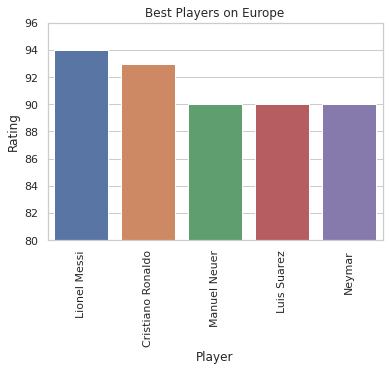

In [16]:
# Ploting player vs ratings
sns.set_theme(style='whitegrid')
fig = sns.barplot(x='player_name', y='overall_rating', data=top_players_rating)
plt.setp(fig.get_xticklabels(), rotation=90)
plt.ylim(80, 96)
fig.set(xlabel='Player', ylabel='Rating', title='Best Players on Europe');

We have find that Lionel Messi and Cristiano Ronaldo are the best players. This data make sense compared with the popular opinion and awards.

<a id='question2'></a>
### Who are the player with higher aggression rating?

To answer this question we will use the agression number provided by each players. The most recent agression rating will be considered. A bar plot can show well the results for this question.

In [17]:
# Sorting by agression and geting the the important values
top_players_aggression = players.sort_values(by=['aggression'], ascending=False)[:5][['player_name', 'aggression']]

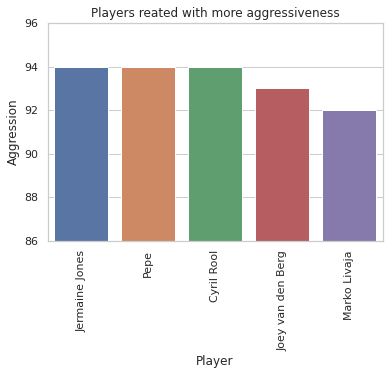

In [18]:
# Ploting player vs aggression
sns.set_theme(style='whitegrid')
fig = sns.barplot(x='player_name', y='aggression', data=top_players_aggression)
plt.setp(fig.get_xticklabels(), rotation=90)
plt.ylim(86, 96)
fig.set(xlabel='Player', ylabel='Aggression', title='Players reated with more aggressiveness');

We have that Jermine Jones, Pepe and Cyril Rool are the most aggressive players on europe. This result make sense once because the mid field and deffend are on agressive is most needed. This players are on that position. 

<a id='question3'></a>
### Is the player rating related to agressiveness?

To answer this question we can plot a relation between the two variables on a scatter plot to have a visual insight about the relation.

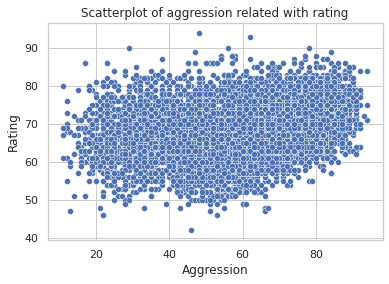

In [19]:
# Ploting rating vs agression
sns.set_theme(style='whitegrid')
fig = sns.scatterplot(x="aggression", y="overall_rating", data=players)
fig.set(xlabel='Aggression', ylabel='Rating', title='Scatterplot of aggression related with rating');

For the data we didn't find any strong corelation for these two parameters. I was expecting to see some corelation here, like better players been less aggressive, but it was not what I find.

<a id='question4'></a>
### How the players are distributed by their physical form (measured by the Body Mass Index).

To answer this question we need to calculate the BMI, that is Weight / (Height * Height). With a histogram we will see the distribution of players BMI.

In [20]:
# Calculating BMI for each player
players['BMI'] = (players['weight'] / 2.205) / ((players['height'] / 100) ** 2)
players.describe()

,player_api_id,overall_rating,aggression,height,weight,BMI
count,11060.000000,11060.000000,11060.000000,11060.000000,11060.000000,11060.000000
mean,156582.427215,67.961935,61.008951,181.867445,168.380289,23.061806
std,160713.700624,6.316694,16.254977,6.369201,14.990217,1.316878
min,2625.000000,42.000000,11.000000,157.480000,117.000000,17.586568
25%,35555.500000,64.000000,52.000000,177.800000,159.000000,22.170941
50%,96619.500000,68.000000,64.000000,182.880000,168.000000,23.051962
75%,212470.500000,72.000000,73.000000,185.420000,179.000000,23.867438
max,750584.000000,94.000000,94.000000,208.280000,243.000000,30.860445


Text(0.5, 1.0, 'BMI distribution')

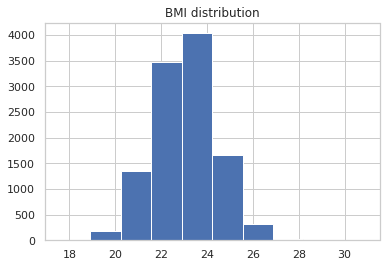

In [21]:
# Ploring a histogram to see the distribution
players['BMI'].hist();
plt.title("BMI distribution")

By the BMI index, below 18.5 is under a healthy weight and above 30 is considered obesity.
By this histogram we can see that professional soccer player in most cases have a good boddy structure.

<a id='question5'></a>
### Teams playing at home won more matchs?

To answer this question we will use the goals difference and a pie chart to show the relative quantity of three different results.

In [22]:
# Intermetiate values to computations
home_victory = complete_match.apply(lambda x: True if x['goals_diff'] > 0 else False , axis=1)
numOfHomeVictory = len(home_victory[home_victory == True].index)

away_victory = complete_match.apply(lambda x: True if x['goals_diff'] < 0 else False , axis=1)
numOfAwayVictory = len(away_victory[away_victory == True].index)

draws_game = complete_match.apply(lambda x: True if x['goals_diff'] == 0 else False , axis=1)
numOfDraws = len(draws_game[draws_game == True].index)

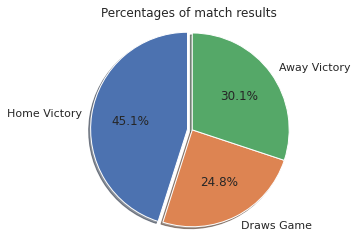

In [23]:
# Ploting a pie chart
labels = 'Home Victory', 'Draws Game', 'Away Victory'
sizes = [numOfHomeVictory, numOfDraws, numOfAwayVictory]
explode = (0.05, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentages of match results")
plt.show()

In our data for 2016 the teams playing at home have won more, at least for the data remaning after the clean. We can see this result is consistent with the mean of goals_diff been 0.37 (witch means more goals for home teams).

In [24]:
complete_match.describe()

,goals_diff,speed_diff,dribbling_diff,passing_diff
count,5593.000000,5593.000000,5593.000000,5593.000000
mean,0.370821,0.087788,0.087431,-0.036295
std,1.897636,14.044177,12.044522,14.673105
min,-9.000000,-54.000000,-47.000000,-55.000000
25%,-1.000000,-9.000000,-7.000000,-10.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,9.000000,7.000000,10.000000
max,7.000000,50.000000,45.000000,47.000000


<a id='question6'></a>
### What teams attributes have correlation with victory when playing at home?

To answer this question we can see the relation between different team attributes against the goals difference.
A good way to see this is with a scatterplot for each variable. We could use the scatter_matrix function but is better visualized as separate plots.

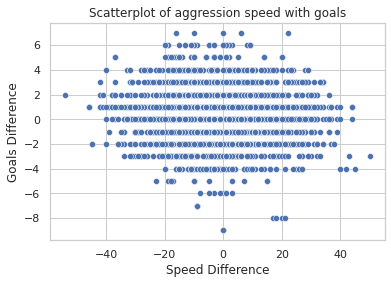

In [25]:
# Ploting speed_diff vs goals_diff
sns.set_theme(style='whitegrid')
fig2 = sns.scatterplot(x="speed_diff", y="goals_diff", data=complete_match)
fig2.set(xlabel='Speed Difference', ylabel='Goals Difference', title='Scatterplot of aggression speed with goals');

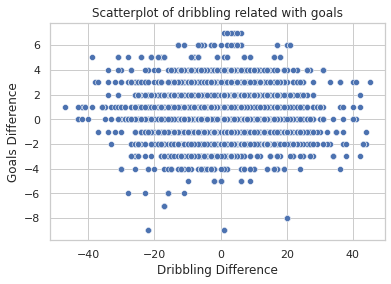

In [26]:
# Ploting dribbling_diff vs goals_diff
sns.set_theme(style='whitegrid')
fig3 = sns.scatterplot(x="dribbling_diff", y="goals_diff", data=complete_match)
fig3.set(xlabel='Dribbling Difference', ylabel='Goals Difference', title='Scatterplot of dribbling related with goals');

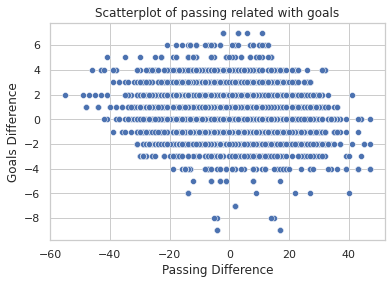

In [27]:
# Ploting passing_diff vs goals_diff
sns.set_theme(style='whitegrid')
fig4 = sns.scatterplot(x="passing_diff", y="goals_diff", data=complete_match)
fig4.set(xlabel='Passing Difference', ylabel='Goals Difference', title='Scatterplot of passing related with goals');

Remmember that the differences are for Home Team minus Away Team.

Visualy we can't see any correlation for Speed and Dribling. About Passing we can see some negative correlation between passing difference and goals diference.

<a id='conclusions'></a>
## Conclusions

The results we showed could help answers the questions we proposed at beginning.
Soccer is a complex game that involves lots of individual performance that it's hard to point definitive solutions about what can work better.

We had some insights about the state of European Soccer while having a great learning while trying to work with this data.

Some limitations are important:

* No statistical tests were applied, so we have only insights but not strong conclusions.
* Many columns in the Match table are empty and it would make analysis more accurate if these values were recorded.
* Some data came from video game, so they may not represent reality.

References used to conclude this project:
* Pandas dataframe documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
* Seaborn documentation: https://seaborn.pydata.org/index.html
* Some stackoverflow varied posts:
* Kaggle page for the data set: https://www.kaggle.com/hugomathien/soccer